# DATA ANALYSIS (RACERS)
In this notebook we are going to asses the quality of the racers dataset provided for the course project


In [479]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path
datasetname=path.join('..','..','..','dataset', 'cyclists.csv')
df=pd.read_csv(datasetname)


## WRONG DATA
To asses which are the wrong data in the dataset we have to check the data type in the dataset.

In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


Just from the info command we can start to see the first problems, the url, name and nationality should be string types, the birth_year should be an Integer type, weight and height are ok to be float64.
Now we can show every element which don't respect the natural type to check what are the problems.

First we check if the object is an inference choice for string values or if there are some kind of null pointer or not accepted values

In [481]:
def wrong_type(valore, tipo_atteso):
    try:
        return not isinstance(valore, tipo_atteso)
    except:
        return True  

### _url

In [482]:
column = '_url'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=str)]

print(wrong_elements[column])

Series([], Name: _url, dtype: object)


As we can see all the elements are str type. Since the url are in the form "name-surname" we can check if for all the rows this rule is respected.

In this case we can see that the main differences between the two column is the replacing of the double whitespace with a '-' (name-surname), the replace of the singular withespace with a '-' (first name-second name) and the standardization of the letters with accent in the base form (è in e) .

In [483]:
import unicodedata

def remove_accent(text):
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    return text

differences = df[df['name'].apply(remove_accent).str.lower().str.replace('  ', '-').str.replace(' ','-') != df['_url']]

print(differences[['name', '_url']])

                         name                            _url
19             Michał  Paluta                   michal-paluta
25        Graeme Allen  Brown                    graeme-brown
32           Piotr  Przydział                 piotr-przydzial
49           Jesús  Rodríguez       jesus-rodriguez-rodriguez
68              Ivan  Herrero           iban-herrero-atienzar
...                       ...                             ...
6093  Raúl Alexander  Montaña  raul-alexander-montana-herrera
6112     Juan Carlos  Jusdado      juan-carlos-jusdado-ibanez
6113           Joseba  Albizu            joseba-albizu-lizaso
6121         Jacob  Hindsgaul          jacob-hindsgaul-madsen
6129      Juan José  Martínez         juan-jose-martinez-diaz

[618 rows x 2 columns]


From this analysis we can see that there are 618 rows which don't respect the main conversion rules, some with missin elements (second name or surname) and some with wrong characters. In some cases in the '_url' there are more information in respect of the 'name' column, because of that it's better to split the column 'name' in 'name' and 'surname' ('secondname' could cause too many empty elements) and rebuild the full name of every rider thanks to the column with more information.

In [484]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes '_url': []
Numbner of missing values '_url': 0


We have no missing values in this column.

### name

In [485]:
column = 'name'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=str)]

print(wrong_elements[column])

Series([], Name: name, dtype: object)


In [486]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes 'name': []
Numbner of missing values 'name': 0


We have no missing values for this column

### birth_year

In [487]:
column = 'birth_year'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=int)]

print(wrong_elements[column])

0       1964.0
1       1965.0
2       1996.0
3       1995.0
4       1997.0
         ...  
6129    1966.0
6130    1998.0
6131    1973.0
6132    1985.0
6133    1999.0
Name: birth_year, Length: 6134, dtype: float64


All the elements of birth year type are float, not int but for computation reason. Let's only check if there are elements with number after the last digit.


In [488]:
column = 'birth_year'
decilmal_elements = df[df[column] % 1 != 0]

print(decilmal_elements[column])


9      NaN
601    NaN
894    NaN
2408   NaN
2515   NaN
2536   NaN
3046   NaN
3551   NaN
4142   NaN
4384   NaN
4756   NaN
6072   NaN
6080   NaN
Name: birth_year, dtype: float64


We can see that all the birth year with a decimal part ar Nan so for this section of the analysis it's fine.

In [489]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes 'birth_year': [9, 601, 894, 2408, 2515, 2536, 3046, 3551, 4142, 4384, 4756, 6072, 6080]
Numbner of missing values 'birth_year': 13


### nationality

In [490]:
df['nationality'].head()

0          Italy
1         France
2    Netherlands
3        Belgium
4          Spain
Name: nationality, dtype: object

In [491]:
column = 'nationality'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=str)]

print(wrong_elements[column])

9    NaN
Name: nationality, dtype: object


Before changing the type of the column we have to remove the Nan values but it's another study case so we leave in this state. Another verification we can do is if the nationality corresponds to a real state and there are no wrong entries, to do this we can use pycountry.

In [492]:
import pycountry

valid_nat = {country.name.lower() for country in pycountry.countries}

unvalid_nat = []

for nat in df['nationality']:
    if nat is not None:
        if str(nat).lower() not in valid_nat:
            unvalid_nat.append(nat)

number_unvalid_nat = len(unvalid_nat)

print(f"Number of not valid country: {number_unvalid_nat}")
if number_unvalid_nat > 0:
    print("Not valid nationality:")
    print(unvalid_nat)


Number of not valid country: 310
Not valid nationality:
[nan, 'Russia', 'Great Britain', 'Russia', 'Great Britain', 'Great Britain', 'Yugoslavia', 'Russia', 'Russia', 'Great Britain', 'Czech Republic', 'Czech Republic', 'Russia', 'Russia', 'Great Britain', 'Russia', 'Russia', 'Great Britain', 'Great Britain', 'Russia', 'Russia', 'Russia', 'Czech Republic', 'Russia', 'Great Britain', 'Great Britain', 'Russia', 'Great Britain', 'Great Britain', 'Venezuela', 'Russia', 'Russia', 'Russia', 'Great Britain', 'Russia', 'Russia', 'Great Britain', 'Russia', 'Russia', 'Russia', 'Russia', 'Great Britain', 'Czech Republic', 'Russia', 'Czech Republic', 'Great Britain', 'Russia', 'Russia', 'Russia', 'Great Britain', 'Great Britain', 'Taiwan', 'Czech Republic', 'Moldova', 'Russia', 'Russia', 'Russia', 'Great Britain', 'Russia', 'Czech Republic', 'Great Britain', 'Great Britain', 'Iran', 'Great Britain', 'Great Britain', 'Great Britain', 'Venezuela', 'Russia', 'Russia', 'Venezuela', 'Russia', 'Great Br

The not valid nation are in most cases real nation not considered by the library, we can add some exception to handle this case

In [493]:
corr_nat = {
    'russia': 'russian federation',
    'great britain': 'united kingdom',
    'yugoslavia': 'serbia',
    'czech republic': 'czechia',
    'taiwan': 'taiwan, province of china',
    'venezuela': 'venezuela, bolivarian republic of',
    'iran': 'iran, islamic republic of',
    'moldova': 'moldova, republic of',
}

unvalid_nat = []

for nat in df['nationality']:
    if nat is None:
        continue
    nat_lower = str(nat).lower()
    if nat_lower in corr_nat:
        nat_lower = corr_nat[nat_lower]
    
    if nat_lower not in valid_nat:
        unvalid_nat.append(nat)

number_unvalid_nat = len(unvalid_nat)

print(f"Number of not valid nationality: {number_unvalid_nat}")
if number_unvalid_nat > 0:
    print("Not valid nationality:")
    print(unvalid_nat)

Number of not valid nationality: 2
Not valid nationality:
[nan, 'Hongkong']


The last nation which is still invalid is hong kong, in pycountry is 'hong kong' let's see if its the only one entry or if it's a typo

In [494]:
hong_kong = df[df['nationality'].str.lower() == 'hong kong']

print(hong_kong)

Empty DataFrame
Columns: [_url, name, birth_year, weight, height, nationality]
Index: []


It's not a typo so we can conclude that every country is valid.

In [495]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes 'nationality': [9]
Numbner of missing values 'nationality': 1


### height

In [496]:
column = 'height'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=int)]

print(wrong_elements[column])

0         NaN
1       182.0
2       189.0
3       192.0
4       171.0
        ...  
6129      NaN
6130    188.0
6131      NaN
6132    170.0
6133    186.0
Name: height, Length: 6134, dtype: float64


In [497]:
column = 'height'
decilmal_elements = df[df[column] % 1 != 0]
# remove nan
decilmal_elements = decilmal_elements[~decilmal_elements[column].isna()]
print(len(decilmal_elements[column]))

0


In [498]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes 'height': [0, 6, 9, 10, 13, 14, 18, 20, 26, 29, 30, 31, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 52, 53, 56, 59, 63, 64, 67, 68, 70, 71, 72, 85, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102, 104, 106, 111, 113, 114, 115, 117, 121, 122, 123, 125, 126, 128, 129, 130, 132, 133, 138, 140, 142, 143, 145, 148, 150, 151, 152, 153, 158, 161, 163, 168, 169, 171, 172, 176, 178, 179, 181, 183, 188, 189, 191, 197, 198, 199, 201, 202, 205, 206, 208, 209, 210, 213, 214, 215, 217, 220, 221, 222, 223, 231, 233, 236, 238, 241, 242, 245, 247, 248, 249, 250, 251, 253, 254, 255, 256, 259, 262, 265, 266, 269, 270, 273, 274, 276, 279, 281, 284, 286, 289, 293, 297, 299, 300, 301, 303, 306, 307, 308, 310, 312, 313, 314, 315, 316, 317, 323, 326, 328, 329, 330, 332, 334, 337, 339, 340, 341, 343, 345, 351, 352, 353, 359, 360, 366, 368, 369, 370, 371, 373, 374, 375, 378, 379, 380, 383, 384, 390, 391, 392, 393, 395, 397, 405, 407, 410, 411, 412, 413, 415, 416, 420, 423, 429, 431, 435, 437, 438, 442, 443, 4

### Weight

In [499]:
column = 'weight'
wrong_elements = df[df[column].apply(wrong_type, tipo_atteso=int)]

print(wrong_elements[column])

0        NaN
1       74.0
2       69.0
3       78.0
4       55.0
        ... 
6129     NaN
6130    75.0
6131     NaN
6132    58.0
6133    75.0
Name: weight, Length: 6134, dtype: float64


In [500]:
column = 'weight'
decilmal_elements = df[df[column] % 1 != 0]
# remove nan
decilmal_elements = decilmal_elements[~decilmal_elements[column].isna()]
print(f"Elements with decimal values: {len(decilmal_elements[column])}")
print(decilmal_elements[column])

Elements with decimal values: 15
7       71.5
620     67.5
1313    58.5
1629    63.5
1741    63.5
1873    74.5
2046    66.5
2323    78.1
2363    77.5
2471    81.4
2581    58.5
4181    62.5
4744    73.5
4772    79.5
4947    65.1
Name: weight, dtype: float64


In [501]:
nan_indexes = df.index[df[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")

Nan indexes 'weight': [0, 6, 9, 10, 13, 14, 18, 20, 26, 29, 30, 31, 37, 39, 40, 41, 44, 45, 46, 47, 48, 49, 52, 53, 56, 59, 63, 64, 67, 68, 70, 71, 72, 76, 85, 90, 91, 93, 94, 95, 96, 98, 100, 101, 102, 104, 106, 111, 113, 115, 117, 121, 122, 123, 125, 126, 128, 129, 130, 132, 133, 138, 140, 142, 143, 145, 148, 150, 151, 152, 153, 158, 161, 163, 168, 169, 171, 172, 176, 178, 179, 181, 183, 188, 189, 191, 197, 198, 199, 201, 202, 205, 206, 208, 209, 210, 213, 214, 215, 217, 219, 220, 221, 222, 223, 231, 233, 236, 238, 241, 242, 245, 247, 248, 249, 250, 251, 253, 254, 255, 256, 259, 261, 262, 265, 266, 269, 270, 273, 274, 276, 279, 281, 284, 286, 289, 293, 297, 299, 300, 301, 303, 306, 307, 308, 310, 312, 313, 314, 315, 316, 317, 323, 326, 328, 329, 330, 332, 334, 337, 339, 340, 341, 343, 345, 351, 352, 353, 355, 359, 360, 366, 368, 369, 370, 371, 373, 374, 375, 378, 379, 380, 383, 384, 390, 391, 392, 393, 395, 397, 403, 405, 406, 407, 410, 411, 412, 413, 415, 416, 420, 423, 429, 431, 43

## DUPLICATE DATA
For this task we can check three things:

- Row which are the exact identical
- Row with the same _url (our identifier)
- Row with the same name

In [502]:
same_rows = df.duplicated(keep=False)  

url_duplicates = df.duplicated(subset=['_url'], keep=False) 

name_duplicates = df.duplicated(subset=['name'], keep=False) 


print(f"Number of identical row: {same_rows.sum()}")
print(f"Number of row with same _url: {url_duplicates.sum()}")
print(f"Number of row with same name: {name_duplicates.sum()}")

Number of identical row: 0
Number of row with same _url: 0
Number of row with same name: 14


We can see that the number of identical row is zero but we found 14 rows with same name, let's check them.

In [503]:
print(df[name_duplicates][['name', '_url']])

                    name                        _url
347        Andrea  Peron              andrea-peron-1
1745    Roman  Kreuziger          roman-kreuziger-sr
2235   Alessandro  Pozzi           alessandro-pozzi2
2601    Roman  Kreuziger             roman-kreuziger
2682       Andrea  Peron                andrea-peron
2862    Antonio  Cabello       antonio-cabello-baena
2939        Jesús  López               jesus-lopez23
2953  Alberto  Fernández     alberto-fernandez-sainz
3238    Antonio  Cabello             antonio-cabello
4917   Sergio  Domínguez  sergio-dominguez-rodriguez
4919   Sergio  Domínguez      sergio-dominguez-munoz
5040        Jesús  López          jesus-lopez-carril
5720  Alberto  Fernández    alberto-fernandez-blanco
5722   Alessandro  Pozzi            alessandro-pozzi


In this case the disambuigation is not so trivial, some times the duplicates are converted with a number after the classical url convertion, other ones it's converted with different information (second name). This makes the direct conversion harder but if we consider only the url as the identifier we have a well defined dataset in this case. Suggestion: redifinition of the url identifier in a clearly way :

Name Second Surname in name-second-surname(number if there are identical name)

## MISSING VALUES CORRELATION

### Weight-Height

In [504]:
both_missing = df['height'].isnull() & df['weight'].isnull()

count_both_missing = both_missing.sum()

only_one_missing = ((df['height'].isnull()) & (~df['weight'].isnull())) | ((~df['height'].isnull()) & df['weight'].isnull())

count_one_missing = only_one_missing.sum()

print(f"Missing values for both column (height e weight): {count_both_missing}")
print(f"Missing values in just one column (height o weight): {count_one_missing}")

Missing values for both column (height e weight): 2984
Missing values in just one column (height o weight): 79


In this case we can see that rarely the value miss in just one column so we can conclude that a separate analysis it's pointless.

### Nationality

Some country have poor anagraphical system so can be intresting to view the correlation between theese two parameters

We can view the same with the height feature

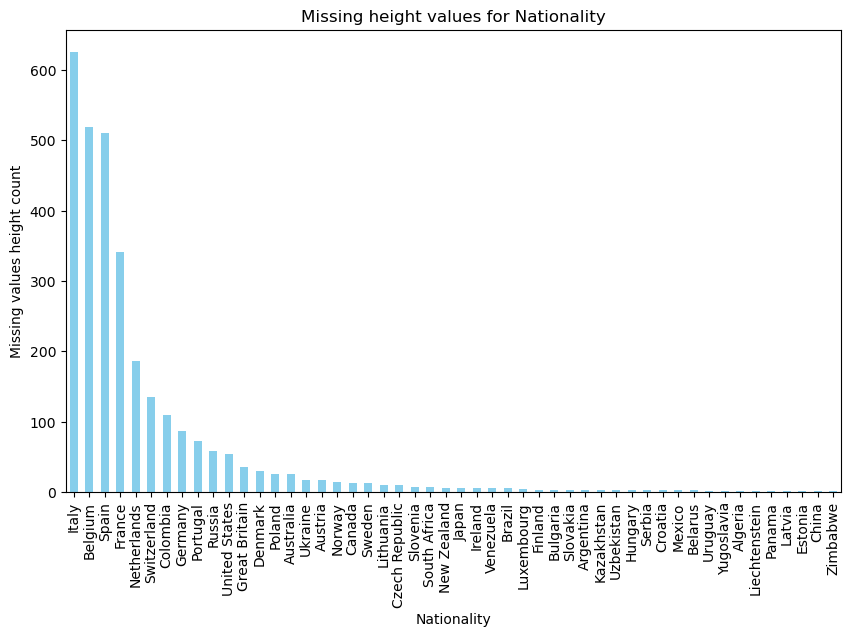

In [505]:
missing_values = df[['nationality', 'height']].isnull()

missing_by_country = missing_values.groupby(df['nationality']).sum()

missing_by_country = missing_by_country[missing_by_country['height'] > 0]

missing_by_country = missing_by_country.sort_values(by='height', ascending=False)

plt.figure(figsize=(10, 6))
missing_by_country['height'].plot(kind='bar', color='skyblue')
plt.title('Missing height values for Nationality')
plt.xlabel('Nationality')
plt.ylabel('Missing values height count')
plt.xticks(rotation=90)
plt.show()

### Birth Year

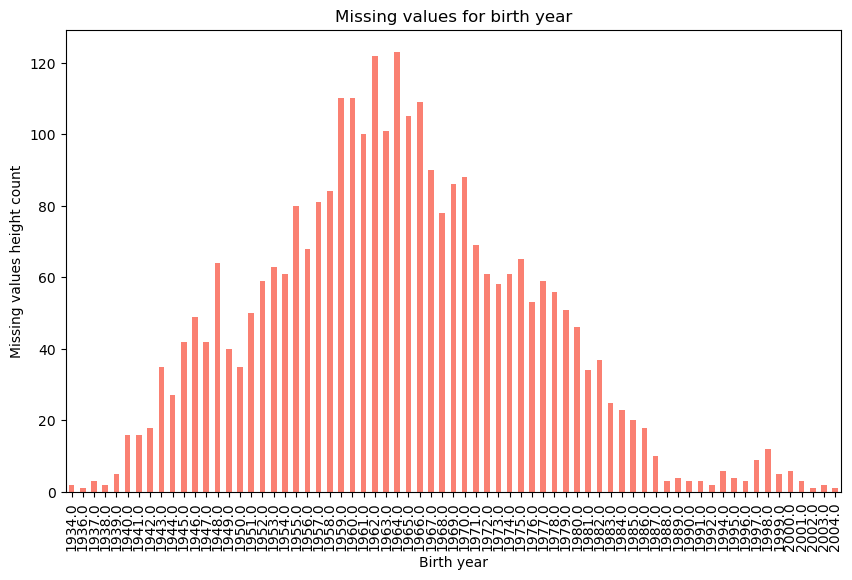

In [506]:
missing_values = df[['birth_year', 'height']].isnull()

missing_by_year = missing_values.groupby(df['birth_year']).sum()

missing_by_year = missing_by_year[missing_by_year['height'] > 0]

missing_by_year = missing_by_year.sort_index()

plt.figure(figsize=(10, 6))
missing_by_year['height'].plot(kind='bar', color='salmon')
plt.title('Missing values for birth year')
plt.xlabel('Birth year')
plt.ylabel('Missing values height count')
plt.xticks(rotation=90)
plt.show()

# FIXING THE DATA
We write all the fixes on a new dataframe.

In [507]:
df2 = df.copy()

## REMOVING OUTLIERS
Thanks to the analysis in the data_distribution notebook we can remove the outliers in the column affected.

### birth_year

In [508]:
from utils import find_outliers

birth_year_outliers = find_outliers(df2, "birth_year")
print("Number of outliers for birth_year:", len(birth_year_outliers))

outlier_indices = birth_year_outliers.index

# remove outliers from birth_year column
df2.loc[outlier_indices, 'birth_year'] = None
birth_year_outliers = find_outliers(df2, "birth_year")
print("Number of outliers for birth_year:", len(birth_year_outliers))

Number of outliers for birth_year: 0
Number of outliers for birth_year: 0


### weight

In [509]:
weight_outliers = find_outliers(df2, "weight")
print("Number of outliers for weight:", len(weight_outliers))

outlier_indices = weight_outliers.index

# remove outliers from weight column
df2.loc[outlier_indices, 'weight'] = None
weight_outliers = find_outliers(df2, "weight")
print("Number of outliers for weight:", len(weight_outliers))

Number of outliers for weight: 19
Number of outliers for weight: 0


### height

In [510]:
height_outliers = find_outliers(df2, "height")
print("Number of outliers for height:", len(height_outliers))

outlier_indices = height_outliers.index

# remove outliers from weight column
df2.loc[outlier_indices, 'height'] = None
weight_outliers = find_outliers(df2, "height")
print("Number of outliers for height:", len(weight_outliers))

Number of outliers for height: 22
Number of outliers for height: 0


## MISSING VALUES

### Nationality
Since we have just one missing value for this column we can search online the nationality of the cyclist or at least assign the most frequent one.
[ProCyclingStats](https://www.procyclingstats.com/rider)

In [511]:
print(df2.iloc[9])

_url            scott-davies
name           Scott  Davies
birth_year               NaN
weight                   NaN
height                   NaN
nationality              NaN
Name: 9, dtype: object


In [512]:
df2.at[9, 'nationality'] = 'Great Britain'

### birth_year
Since we have just 13 missing values we can search online the birth year, otherwise we can use the most frequent birth year.


In [513]:
column='birth_year'
nan_indexes = df2.index[df2[column].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")
print(f"Name of the missing values '{column}':\n {df2.loc[nan_indexes, 'name']}")

Nan indexes 'birth_year': [9, 601, 894, 2408, 2515, 2536, 3046, 3551, 4142, 4384, 4756, 6072, 6080]
Numbner of missing values 'birth_year': 13
Name of the missing values 'birth_year':
 9             Scott  Davies
601       Vladimir  Malakov
894         Antonio  Zanini
2408     Filippo  Simonetti
2515         Carlos  García
2536       Alexandr  Osipov
3046      Nicolai  Kosyakov
3551            Guy  Nevens
4142           Oscar  Pumar
4384         Javier  Luquin
4756        Thierry  Lauder
6072    Sergei  Jermachenko
6080       Batik  Odriozola
Name: name, dtype: object


In [514]:
df2.at[9, 'birth_year'] = 1995
df2.at[601, 'birth_year'] = 1958
df2.at[894, 'birth_year'] = 1965
df2.at[2408, 'birth_year'] = 0

df2.at[2515, 'birth_year'] = 1958

df2.at[2536, 'birth_year'] = 0
df2.at[3046, 'birth_year'] = 0
df2.at[3551, 'birth_year'] = 0
df2.at[4142, 'birth_year'] = 1970
df2.at[4384, 'birth_year'] = 0
df2.at[4756, 'birth_year'] = 0
df2.at[6072, 'birth_year'] = 0
df2.at[6080, 'birth_year'] = 1970

Now we can replace the rest with the most frequent value

In [515]:
most_frequent_value = df2['birth_year'].mode()[0]
df2['birth_year'] = df2['birth_year'].replace(0, most_frequent_value)
nan_indexes = df2.index[df2['birth_year'].isna()].tolist()

print(f"Nan indexes '{column}': {nan_indexes}")
print(f"Numbner of missing values '{column}': {len(nan_indexes)}")
print(f"Name of the missing values '{column}': {df2.loc[nan_indexes, 'name']}")


Nan indexes 'birth_year': []
Numbner of missing values 'birth_year': 0
Name of the missing values 'birth_year': Series([], Name: name, dtype: object)


### Weight - Height

Since these two feature are so correlated we decide to fill the missing values togheter. The reason behind this choice is to mantain a correlation between the two value and return a meaningful value for each entry. First we decide to randomly fill the rows where both feature is missing.

In [516]:
import numpy as np

df2[['height', 'weight']] = df2[['height', 'weight']].apply(pd.to_numeric, errors='coerce')

np.random.seed(1)

both_missing = df2['height'].isnull() & df2['weight'].isnull()
count_both_missing = both_missing.sum()
print(f"Missing values for both columns (height and weight): {count_both_missing}")

# Keep valid rows for substitution
valid_rows = df2.dropna(subset=['weight', 'height'])
print(f"Valid rows available for substitution: {len(valid_rows)}")
missing_rows = df2[both_missing].index

for index in missing_rows:
    substitute_row = valid_rows.sample(n=1, replace=True)
    df2.at[index, 'weight'] = substitute_row['weight'].values[0]
    df2.at[index, 'height'] = substitute_row['height'].values[0]


both_missing = df2['height'].isnull() & df2['weight'].isnull()
count_both_missing = both_missing.sum()
print(f"Missing values for both columns after replacement: {count_both_missing}")


Missing values for both columns (height and weight): 2993
Valid rows available for substitution: 3039
Missing values for both columns after replacement: 0


Now we can build a distribution model for the singular missing values based on the present one. For example, if only height is missing the model will choose height randomly in rows with that weight and viceversa, if the value misses it will chose the nearest one. This solution couldn't be the best one due to poor correlation between the two features (0.33) but it's better than a random shot.

In [517]:
np.random.seed(1)

height_missing = df2['height'].isnull()
count_height_missing = height_missing.sum()
print(f"Missing values for height: {count_height_missing}")

# Keep valid rows for substitution
valid_rows = df2.dropna(subset=['height'])
print(f"Valid rows available for substitution: {len(valid_rows)}")
missing_rows = df2[height_missing].index


for index in missing_rows:

    candidate_rows = valid_rows[valid_rows['weight'] == df.at[index, 'weight']]

    if len(candidate_rows) > 0:
        substitute_row = candidate_rows.sample(n=1, replace=True)

    else:
        # We have to add this check due to a bug in pandas
        temp_rows = valid_rows[valid_rows.index != index]
        temp_rows['difference'] = (temp_rows['weight'] - df2.at[index, 'weight']).abs()
        minimal_difference = temp_rows['difference'].min()
        nearest_rows = temp_rows[temp_rows['difference'] == minimal_difference]

        substitute_row = nearest_rows.sample(n=1, replace=True)

        temp_rows = temp_rows.drop(columns='difference')
    
    df2.at[index, 'height'] = substitute_row['height'].values[0]


height_missing = df2['height'].isnull()
print(height_missing[0])
count_height_missing = height_missing.sum()
print(f"Missing values for height column after replacement: {count_height_missing}")
print(df2.loc[height_missing, ['name', 'weight', 'height']])


Missing values for height: 20
Valid rows available for substitution: 6114
False
Missing values for height column after replacement: 0
Empty DataFrame
Columns: [name, weight, height]
Index: []


In [518]:
np.random.seed(1)

height_missing = df2['weight'].isnull()
count_height_missing = height_missing.sum()
print(f"Missing values for weight: {count_height_missing}")

# Keep valid rows for substitution
valid_rows = df2.dropna(subset=['weight'])
print(f"Valid rows available for substitution: {len(valid_rows)}")
missing_rows = df2[height_missing].index


for index in missing_rows:

    candidate_rows = valid_rows[valid_rows['height'] == df.at[index, 'height']]

    if len(candidate_rows) > 0:
        substitute_row = candidate_rows.sample(n=1, replace=True)

    else:
        # We have to add this check due to a bug in pandas
        temp_rows = valid_rows[valid_rows.index != index]
        temp_rows['difference'] = (temp_rows['height'] - df2.at[index, 'height']).abs()
        minimal_difference = temp_rows['difference'].min()
        nearest_rows = temp_rows[temp_rows['difference'] == minimal_difference]

        substitute_row = nearest_rows.sample(n=1, replace=True)

        temp_rows = temp_rows.drop(columns='difference')
    
    df2.at[index, 'weight'] = substitute_row['weight'].values[0]


height_missing = df2['weight'].isnull()
print(height_missing[0])
count_height_missing = height_missing.sum()
print(f"Missing values for weight column after replacement: {count_height_missing}")
print(df2.loc[height_missing, ['name', 'weight', 'height']])


Missing values for weight: 82
Valid rows available for substitution: 6052
False
Missing values for weight column after replacement: 0
Empty DataFrame
Columns: [name, weight, height]
Index: []


In [519]:
both_missing = df2['height'].isnull() & df2['weight'].isnull()

count_both_missing = both_missing.sum()

only_one_missing = ((df2['height'].isnull()) & (~df2['weight'].isnull())) | ((~df2['height'].isnull()) & df2['weight'].isnull())

count_one_missing = only_one_missing.sum()

print(f"Missing values for both column (height e weight): {count_both_missing}")
print(f"Missing values in just one column (height o weight): {count_one_missing}")

Missing values for both column (height e weight): 0
Missing values in just one column (height o weight): 0


## DATA TYPE CASTING
For each column we cast the column with the most common type for that kind of data.


In [520]:
df2['name'] = df2['name'].astype(str)
df2['birth_year'] = df2['birth_year'].astype(int)
df2['nationality'] = df2['nationality'].astype(str)
df2['height'] = df2['height'].astype(int)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6134 non-null   int64  
 3   weight       6134 non-null   float64
 4   height       6134 non-null   int64  
 5   nationality  6134 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 287.7+ KB


In [521]:
# Save the cleaned dataset
df2.to_csv(path.join('..','..','..','dataset', 'cyclists_cleaned.csv'), index=False)

# FEATURE ENGINEERING

## COLUMN REDEFINITION


### Name
The first column to be redefined is the name, in the base dataset the conversion from the url is counterintuitive and include ambiguous informations.
We have to check if exists name with more than 3 entry.

In [522]:
df3 = pd.read_csv(path.join('..','..','..','dataset', 'cyclists_cleaned.csv'))

colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split()))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
6       1
5      10
4     116
3     757
2    5250
Name: count, dtype: int64


In this case we have to check if there are name with more surname.

In [523]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)

name
3       1
2    5750
1     383
Name: count, dtype: int64


We can see that we have name without surname and names with two surnames.

In [524]:
conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

dataset_3_parole = df[conteggio_parole == 3]
dataset_1_parola = df[conteggio_parole == 1]

dataset_3_parole.head()


,_url,name,birth_year,weight,height,nationality
1009,jose-luis-roldan,Jose Luis Roldán,1985.0,61.0,175.0,Spain


In [525]:
df3.at[1009, 'name'] = 'Jose Luis  Roldán'

We infer the convention that the last word in the name is the surname so we standardize the format (name-whitespace for each second name-surname)

In [526]:
def add_whitespace(string):
    parole = string.split("  ")
    if len(parole) == 1:
        wordsplitted = string.split(' ')
        wordsplitted[-1] = ' ' + parole[-1] 
        return ' '.join(wordsplitted)
    return string

df3['name'] = colonna.apply(add_whitespace)

In [527]:
colonna = df3['name']

conteggio_parole = colonna.apply(lambda x: len(str(x).split("  ")))

distribuzione = conteggio_parole.value_counts().sort_index(ascending=False)

print(distribuzione)


name
2    6134
Name: count, dtype: int64


Now that we have standardized name format we can check the url, remembering the previously convention, surname are formed with one word so all the strings before the last "-" are part of the name. In the wrong values section we have seen cases where misses the last word of the surname so we can apply 2 strategies:
- Where the url has more entry than the name we put the new part in the name in a position based on the url position. So if we find name-surname-(another string) and the another string is missing in the name part that will be part of the surname, the same for the second name
- Where the name has more entry than the url we fill the url adding "-" at the right point

Adding information to name from the url.


In [528]:
import re

def normalize_text(testo):
    testo_normale = unicodedata.normalize('NFD', testo)
    testo_senza_accenti = ''.join([c for c in testo_normale if unicodedata.category(c) != 'Mn'])
    testo_finale = re.sub(r'[^a-zA-Z0-9\s]', '', testo_senza_accenti)
    return testo_finale


def fix_name(stringurl, stringname):

    stringfixed = stringurl.replace('-',' ').lower()
    stringfixed = re.sub(r'\d+', '', stringfixed)
    stringfixed = stringfixed.title()
    vettoreurl = stringfixed.split()
    
    stringnamefixed = normalize_text(stringname)
    vettorename = re.split(r'\s+', stringnamefixed)
    # Index of the double space in the name
    match = re.search(r'  ', stringname)
    
    if len(vettoreurl) == len(vettorename):
        return stringname
    length = 0

    for indiceurl in range(len(vettoreurl)):
        length += len(vettoreurl[indiceurl])
        if vettoreurl[indiceurl] not in vettorename:
            vettorename.insert(indiceurl, vettoreurl[indiceurl])
            # Second name found, doble space position is changed
            if length < match:
                match = match + len(vettoreurl[indiceurl])
        length = length+1
    #Adding the doublespace of the surname
    nuovoname = ' '.join(vettorename)
    fixedname = nuovoname[:match] + ' ' + nuovoname[match:]
    return fixedname


Create new url through fixed conversion rule. (CAPIRE SE HA SENSO CAMBIARE URL)

## ADDING COLUMN

### Weight - Height => BMI
For a further study we add the BMI index, the calculation is weight/(height[m])*2

In [529]:
df3['bmi'] = df3['weight'] / (df3['height'] / 100) ** 2

### FEATURE FROM RACES DATASET

In [530]:
from utils import handle_missing_df

RACES_DATASET_PATH = path.join('..','..','..','dataset', 'races_cleaned.csv')
dfraces= pd.read_csv(RACES_DATASET_PATH)

dfraces.head()


,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,france-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,spain-1991,0.0


### CARREER POINTS
Questa è la misura più complessa e riassume la carriera del ciclista registrata nel dataset.
Per farlo sommiamo il punteggio ottenuto totale 

In [531]:

df3['career_points'] = 0

career_points = dfraces.groupby('cyclist')['points'].sum()

df3['career_points'] = df3['_url'].map(career_points)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0


### CARREER DURATION
Con questa feature misuriamo la durata totale della carriera di un ciclista, in numero di gare, in giorni (misurati sull'ultima gara disponibile meno la prima) e sull'anno della prima gara.

In [532]:


dfraces['date'] = pd.to_datetime(dfraces['date'], format='%Y-%m-%d %H:%M:%S')
carreerduration = dfraces.groupby('cyclist')['date'].agg(lambda x:((x.max() - x.min()).days+1))
df3['career_duration(days)'] = df3['_url'].map(carreerduration)


df3['career_duration(races)'] = 0
carreerdurationraces = dfraces.groupby('cyclist').size()
df3['career_duration(races)'] = df3['_url'].map(carreerdurationraces)

df3['first_race_year'] = 0
firstraceyear = dfraces.groupby('cyclist')['date'].min().dt.year
df3['first_race_year'] = df3['_url'].map(firstraceyear)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),first_race_year
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0


### AVERAGE POSITIONING

In [533]:

df3['avg_pos'] = 0

career_points = dfraces.groupby('cyclist')['position'].mean()

df3['avg_pos'] = df3['_url'].map(career_points)

df3.head()


,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),first_race_year,avg_pos
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000


In [534]:
df3.to_csv(path.join('..','..','..','dataset', 'cyclists_final_enhanced.csv'), index=False)

## ENANCED ANALYSIS
Now we'll do further analysis on the newer feature ad the correlation between them and the previous ones